In [1]:
# !pip install Cython

In [2]:
# %cd test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import time
import shutil
import torch.nn as nn
from skimage import io
import torchvision
import cv2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from albumentations.pytorch import ToTensorV2
from torchvision import utils

from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,
                            Compose, GaussNoise)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = DEVICE

In [3]:
!pwd

/kaggle/working


In [4]:

BASE_DIR = "../input/tensorflow-great-barrier-reef/train_images/"

NUM_EPOCHS = 12

In [5]:
train_df = pd.read_csv("../input/tensorflow-great-barrier-reef/train.csv")
train_df.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
0,0,40258,0,0,0-0,[]
1,0,40258,1,1,0-1,[]
2,0,40258,2,2,0-2,[]
3,0,40258,3,3,0-3,[]
4,0,40258,4,4,0-4,[]


In [6]:
type(train_df["image_id"].iloc[20])

str

In [7]:
train_df = pd.read_csv("../input/tensorflow-great-barrier-reef/train.csv")
# train_df['annotations'].iloc[3]
train_df['annotations'] = train_df['annotations'].apply(eval)
func = lambda x: "video_"+x.split("-")[0]+"/"+x.split("-")[1]+".jpg"
# vid_func = lambda x: "video_"+x.split("-")[0]

train_df["img_path"] = train_df["image_id"].apply(func)
# train_df["vid_path"] = train_df["image_id"].apply(vid_func)
train_df.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,img_path
0,0,40258,0,0,0-0,[],video_0/0.jpg
1,0,40258,1,1,0-1,[],video_0/1.jpg
2,0,40258,2,2,0-2,[],video_0/2.jpg
3,0,40258,3,3,0-3,[],video_0/3.jpg
4,0,40258,4,4,0-4,[],video_0/4.jpg


In [8]:
train_df["no_of_bbox"] = train_df["annotations"].apply(lambda x: len(x))
train_df.head(20)

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,img_path,no_of_bbox
0,0,40258,0,0,0-0,[],video_0/0.jpg,0
1,0,40258,1,1,0-1,[],video_0/1.jpg,0
2,0,40258,2,2,0-2,[],video_0/2.jpg,0
3,0,40258,3,3,0-3,[],video_0/3.jpg,0
4,0,40258,4,4,0-4,[],video_0/4.jpg,0
5,0,40258,5,5,0-5,[],video_0/5.jpg,0
6,0,40258,6,6,0-6,[],video_0/6.jpg,0
7,0,40258,7,7,0-7,[],video_0/7.jpg,0
8,0,40258,8,8,0-8,[],video_0/8.jpg,0
9,0,40258,9,9,0-9,[],video_0/9.jpg,0


In [9]:
train_df = train_df[train_df["no_of_bbox"]>0].reset_index(drop=True)
train_df

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,img_path,no_of_bbox
0,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",video_0/16.jpg,1
1,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",video_0/17.jpg,1
2,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",video_0/18.jpg,1
3,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",video_0/19.jpg,1
4,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",video_0/20.jpg,1
...,...,...,...,...,...,...,...,...
4914,2,29859,10628,2856,2-10628,"[{'x': 92, 'y': 532, 'width': 40, 'height': 37}]",video_2/10628.jpg,1
4915,2,29859,10629,2857,2-10629,"[{'x': 78, 'y': 569, 'width': 40, 'height': 37}]",video_2/10629.jpg,1
4916,2,29859,10630,2858,2-10630,"[{'x': 65, 'y': 606, 'width': 41, 'height': 37}]",video_2/10630.jpg,1
4917,2,29859,10631,2859,2-10631,"[{'x': 51, 'y': 643, 'width': 44, 'height': 37}]",video_2/10631.jpg,1


In [10]:
boxes = pd.DataFrame(train_df['annotations'].iloc[19], columns=['x', 'y', 'width', 'height']).astype(float).values
boxes

array([[520., 151.,  78.,  62.],
       [598., 204.,  58.,  32.]])

In [11]:
boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

In [12]:
boxes

array([[520., 151., 598., 213.],
       [598., 204., 656., 236.]])

In [13]:
class ReefDataset:

    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def can_augment(self, boxes):
        box_outside_image = ((boxes[:, 0] < 0).any() or (boxes[:, 1] < 0).any() 
                             or (boxes[:, 2] > 1280).any() or (boxes[:, 3] > 720).any())
        return not box_outside_image
    
    def __getitem__(self, i):

        row = self.df.iloc[i]
        
        image = cv2.imread(f'{BASE_DIR}/{row["img_path"]}', cv2.IMREAD_COLOR)
#         print(f'{BASE_DIR}/{row["img_path"]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /=255.0
        
        
        boxes = pd.DataFrame(row['annotations'], columns=['x', 'y', 'width', 'height']).astype(np.float32).values
        
        # Change from [x_min, y_min, w, h] to [x_min, y_min, x_max, y_max]
#         boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
#         boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        boxes[:, 2] = np.clip(boxes[:, 0] + boxes[:, 2],0,1280)
        boxes[:, 3] = np.clip(boxes[:, 1] + boxes[:, 3],0,720)
        
        n_boxes = boxes.shape[0]
        
        # Calculate the area
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'area': torch.as_tensor(area, dtype=torch.float32),
            
            'image_id': torch.tensor([i]),
            
            
            'labels': torch.ones((n_boxes,), dtype=torch.int64),
            
            
            'iscrowd': torch.zeros((n_boxes,), dtype=torch.int64)            
        }

        if self.transforms and self.can_augment(boxes):
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            if n_boxes > 0:
                target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
        else:
            image = ToTensorV2(p=1.0)(image=image)['image']

        return image, target

    def __len__(self):
        return len(self.df)

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4919 entries, 0 to 4918
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        4919 non-null   int64 
 1   sequence        4919 non-null   int64 
 2   video_frame     4919 non-null   int64 
 3   sequence_frame  4919 non-null   int64 
 4   image_id        4919 non-null   object
 5   annotations     4919 non-null   object
 6   img_path        4919 non-null   object
 7   no_of_bbox      4919 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 307.6+ KB


In [15]:
4918*0.9

4426.2

In [16]:
df_train = train_df.iloc[0: 4427]
df_val = train_df.iloc[4428:4918]

ds_train = ReefDataset(df_train)
ds_val = ReefDataset(df_val)

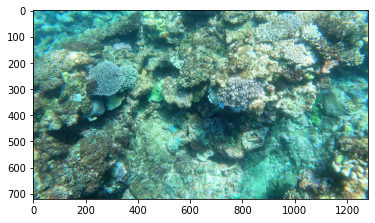

In [17]:
image, targets = ds_train[2200]
# image = image.permute(2,1,0).numpy()
# plt.imshow(image)
img = image.permute(1,2,0).cpu().numpy()
# plt.imshow(image.numpy().reshape((720, 1280,3)))
plt.imshow(img)

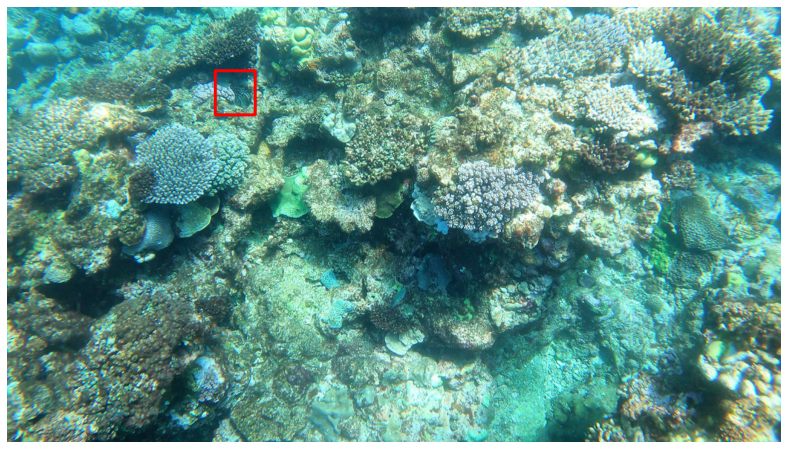

In [18]:
boxes = targets['boxes'].cpu().numpy().astype(np.int32)
img = image.permute(1,2,0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(img,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(img);

In [19]:
def collate_fn(batch):
    return tuple(zip(*batch))

dl_train = DataLoader(ds_train, batch_size=2, shuffle=False, num_workers=4, collate_fn=collate_fn)
dl_val = DataLoader(ds_val, batch_size=2, shuffle=False, num_workers=4, collate_fn=collate_fn)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
def get_model():
    # load a model; pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    num_classes = 2  # 1 class (starfish) + background

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    model.to(device)
    return model

model = get_model()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [21]:
from typing import List

import numpy as np
import torch
from torchvision.ops import box_iou


def calculate_score(
    preds: List[torch.Tensor],
    gts: List[torch.Tensor],
    iou_th: float
) -> float:
    num_tp = 0
    num_fp = 0
    num_fn = 0
    for p, gt in zip(preds, gts):
        if len(p) and len(gt):
            iou_matrix = box_iou(p, gt)
            tp = len(torch.where(iou_matrix.max(0)[0] >= iou_th)[0])
            fp = len(p) - tp
            fn = len(torch.where(iou_matrix.max(0)[0] < iou_th)[0])
            num_tp += tp
            num_fp += fp
            num_fn += fn
        elif len(p) == 0 and len(gt):
            num_fn += len(gt)
        elif len(p) and len(gt) == 0:
            num_fp += len(p)
    if (5 * num_tp + 4 * num_fn + num_fp )!=0:
        score = 5 * num_tp / (5 * num_tp + 4 * num_fn + num_fp )
    else:
        score = np.nan
    if (num_tp+num_fn) != 0:
        recall = num_tp/ (num_tp+num_fn)
    else:
        recall=np.nan
    if (num_tp+num_fp)!=0:
        precission = num_tp/ (num_tp+num_fp)
    else:
        precission=np.nan


    return score, precission, recall




In [22]:


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0025, momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None
confthre = 0.13
n_batches, n_batches_val = len(dl_train), len(dl_val)
validation_losses = []
train_need = True

for epoch in range(NUM_EPOCHS):
    time_start = time.time()
    loss_accum = 0
    
    for batch_idx, (images, targets) in enumerate(dl_train, 1):
        model = model.train()
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Predict
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_accum += loss_value

        # Back-prop
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()
        
    # Validation 
    val_loss_accum = 0
    
    
    iou_ths = np.arange(0.3, 0.85, 0.05)
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(dl_val, 1):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            val_loss_dict = model(images, targets)
#             print(val_loss_dict)
            val_batch_loss = sum(loss for loss in val_loss_dict.values())
            val_loss_accum += val_batch_loss.item()
            
            
    val_f2_scores = []
    
    for batch_idx, (images, targets) in enumerate(dl_val):


        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]     
        model = model.eval()
        preds = model(images)
            
        for i in range(len(images)):
            
#             print(preds[i]['boxes'].dtype)
#             print(preds[i]['scores'].dtype)
#             print(preds[i]['labels'].dtype)

            preds[i]['boxes']=preds[i]['boxes'][preds[i]['scores']>confthre]
            preds[i]['boxes']=preds[i]['boxes'].int()
            score = [calculate_score(preds[i]['boxes'].unsqueeze(0), targets[i]['boxes'].unsqueeze(0), iou_th)[0] for iou_th in iou_ths]
            val_f2_scores.append(np.nanmean(score))
    
    
    # Logging
    val_loss = val_loss_accum / n_batches_val
    train_loss = loss_accum / n_batches
    validation_losses.append(val_loss)
    
    # Save model
    chk_name = f'fasterrcnn_resnet50_fpn-e{epoch}.pth'
    torch.save(model.state_dict(), chk_name)
    
    
    elapsed = time.time() - time_start
    
    print(f"[Epoch {epoch+1:2d} / {NUM_EPOCHS:2d}] Train loss: {train_loss:.3f}. Val loss: {val_loss:.3f} --> {chk_name} val F2: {np.nanmean(val_f2_scores):.3f} time: [{elapsed:.0f} secs] ")   

torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64
torch.float32
torch.float32
torch.int64


KeyboardInterrupt: 

In [ ]:
# sdfj[odjf[osdf]]

In [ ]:
images, boxes = torch.rand(2, 3, 400, 400).to(device), torch.rand(2, 11, 4).to(device)
boxes[:, :, 2:4] = boxes[:, :, 0:2] + boxes[:, :, 2:4]
labels = torch.randint(0, 2, (4, 11)).to(device)
images = list(image for image in images)
targets = []
for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i]
    d['labels'] = labels[i]
    targets.append(d)

In [ ]:
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
model = model.to(DEVICE)
model.eval()
output = model(images)
output